# Summary

<p> This notebook explores behaviour of Amazon customers in a Prime Video org. </p>

<p> The problem at hand is the following: decising makers want to understand how to predict whether a customer will be inactive in the next 6 months. </p>
<p> In other words, this is a classic binary classification problem with a set of features as independent variable and a target identifying whether a customer is inactive (state 0) or active (state 1). </p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("UK_subset.csv")

In [3]:
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,encrypted_customerID,total_units,total_revenue,total_units_ttm,total_revenue_ttm,adj_units_yearly_ever,adj_revenue_yearlu_ever,adj_units_yearly_before_ttm,adj_revenue_yearly_before_ttm,which_promo,...,what_content_type,asp_ever,asp_ttm,arpu_monthly_ever,arpu_monthly_ttm,frequency_days_ever,frequency_days_ttm,hidden_class,tenure_months,target
0,A2GMX5T2DZRSF7,1,0.82,1,0.82,1,1.23,0,0.00,non_promo_user,...,exclusively_movie_vod,0.82,0.82,0.10,0.10,0,0,inept,8.0,0
1,AQRAHLBPDBZ1Y,3,9.48,0,0.00,0,1.67,0,1.67,non_promo_user,...,predominantly_movie_est,3.16,0.00,0.13,0.00,87,0,inept,68.0,0
2,ARDWGB5C81WCO,1,0.82,1,0.82,1,1.09,0,0.00,non_promo_user,...,exclusively_tv,0.82,0.82,0.09,0.09,0,0,inept,9.0,0
3,AJ9WP71ARK0VN,4,4.79,4,4.79,4,5.22,0,0.00,engaged_vendisto_promo,...,exclusively_tv,1.19,1.19,0.43,0.43,16,16,inept,11.0,0
4,AIP4X46PJ7EBE,149,1015.81,24,175.20,35,239.01,29,197.79,non_promo_user,...,predominantly_movie_est,6.81,7.30,19.91,14.60,10,14,hidden_committed,51.0,1


In [4]:
print(df.shape)

(434724, 22)


In [5]:
df.columns

Index(['encrypted_customerID', 'total_units', 'total_revenue',
       'total_units_ttm', 'total_revenue_ttm', 'adj_units_yearly_ever',
       'adj_revenue_yearlu_ever', 'adj_units_yearly_before_ttm',
       'adj_revenue_yearly_before_ttm', 'which_promo', 'engagement',
       'what_content_age', 'what_content_type', 'asp_ever', 'asp_ttm',
       'arpu_monthly_ever', 'arpu_monthly_ttm', 'frequency_days_ever',
       'frequency_days_ttm', 'hidden_class', 'tenure_months', 'target'],
      dtype='object')

# EDA 

## Analyse key metrics by engagement class

<p> From the business perspective, it is important to understand the difference in customer behaviour between engagement classes. Therefore, I start with analysis by engagement classes. </p>

<p> In DE, distribution of customers by engagement shows that 50% of the sample are moderate customers, 30% are one-time and the rest are the engaged. In UK, moderate comprise 44% of the total customer base, 39% are one-time and the rest engaged.  </p>

<p> Also, important to note that engagement classes are defined on trailing twelve months (TTM) basis. Total units and revenue, on the other hand, are recorded for full customer history, therefore the number of units for one-time customers can be larger than one. Interestingly, when looking at average sales price (ASP) for full history, one time turn out to spend slightly more than engaged customers. Another metric - average revenue per user on monthly basis - ARPU - tells another story, namely, that one time customers are muss less worth than engaged ones. </p>

<p> Another interesting finding is that one time customers, those who made just one transaction in the last 12 months, on average (during their lifetime) buy more frequently than moderate customers. </p>

In [6]:
d = df.groupby("engagement")['encrypted_customerID'].nunique().reset_index() 
d['share'] = d['encrypted_customerID'] / d['encrypted_customerID'].sum()

  engagement     share
0    engaged  0.168847
1   moderate  0.443463
2   one_time  0.387690


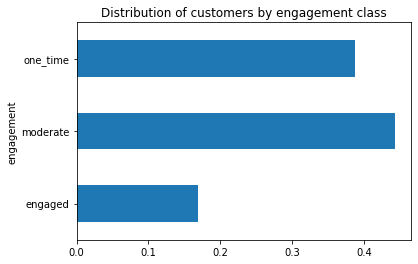

In [7]:
print(d[['engagement','share']])
d.groupby('engagement')['share'].mean().plot.barh()
plt.title('Distribution of customers by engagement class')
plt.show()

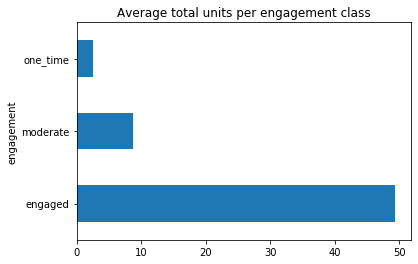

In [8]:
df.groupby("engagement")['total_units'].mean().plot.barh()
plt.title('Average total units per engagement class')
plt.show()

engagement
engaged     4.367515
moderate    4.280666
one_time    4.270320
Name: asp_ever, dtype: float64


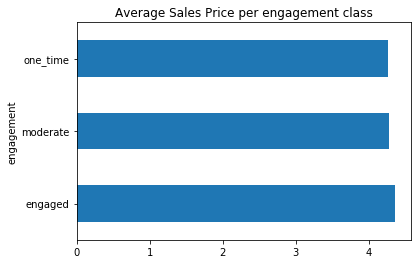

In [9]:
print(df.groupby("engagement")['asp_ever'].mean())
df.groupby("engagement")['asp_ever'].mean().plot.barh()
plt.title('Average Sales Price per engagement class')
plt.show()

engagement
engaged     5.922273
moderate    1.692455
one_time    0.723867
Name: arpu_monthly_ever, dtype: float64


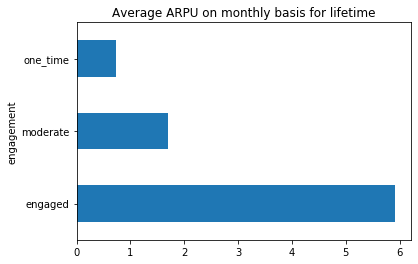

In [10]:
print(df.groupby("engagement")['arpu_monthly_ever'].mean())
df.groupby("engagement")['arpu_monthly_ever'].mean().plot.barh()
plt.title('Average ARPU on monthly basis for lifetime')
plt.show()

engagement
engaged      35.350181
moderate    116.871136
one_time     79.006337
Name: frequency_days_ever, dtype: float64


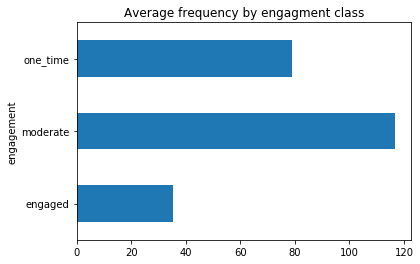

In [11]:
print(df.groupby("engagement")['frequency_days_ever'].mean())
df.groupby("engagement")['frequency_days_ever'].mean().plot.barh()
plt.title('Average frequency by engagment class')
plt.show()

### Analyse key metrics by target value

<p> This section directly addresses the differences in customer behaviour depending on whether a customer is in state 0 (churned) or 1 (active). It means grouping data by target value. </p>
<p> Regarding class count, there seems to be no real class imbalance: in DE, there is 60:40 split in favor of state 1, while in the UK, the split is 48% in state 1 and 52% in state 0. </p>

In [12]:
dt = df.groupby("target")['encrypted_customerID'].nunique().reset_index() 
dt['share'] = dt['encrypted_customerID'] / dt['encrypted_customerID'].sum()

   target     share
0       0  0.523778
1       1  0.476222


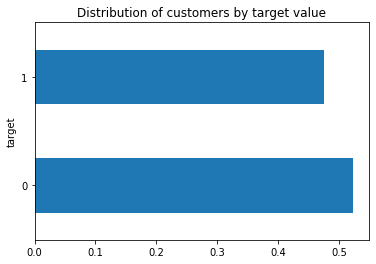

In [13]:
print(dt[['target','share']])
dt.groupby('target')['share'].mean().plot.barh()
plt.title('Distribution of customers by target value')
plt.show()

target
0     5.414481
1    21.788953
Name: total_units, dtype: float64


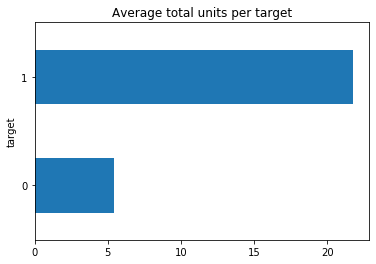

In [14]:
print(df.groupby("target")['total_units'].mean())
df.groupby("target")['total_units'].mean().plot.barh()
plt.title('Average total units per target')
plt.show()

target
0    4.274116
1    4.310241
Name: asp_ever, dtype: float64


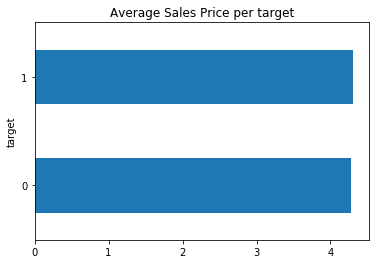

In [15]:
print(df.groupby("target")['asp_ever'].mean())
df.groupby("target")['asp_ever'].mean().plot.barh()
plt.title('Average Sales Price per target')
plt.show()

target
0    1.058576
1    4.350298
Name: asp_ttm, dtype: float64


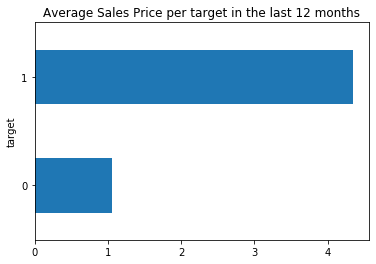

In [16]:
print(df.groupby("target")['asp_ttm'].mean())
df.groupby("target")['asp_ttm'].mean().plot.barh()
plt.title('Average Sales Price per target in the last 12 months')
plt.show()

target
0    0.627584
1    3.615245
Name: arpu_monthly_ever, dtype: float64


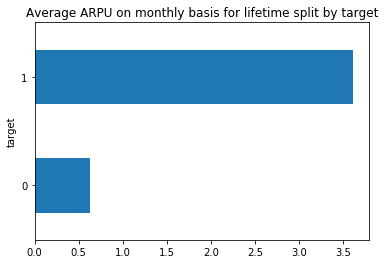

In [17]:
print(df.groupby("target")['arpu_monthly_ever'].mean())
df.groupby("target")['arpu_monthly_ever'].mean().plot.barh()
plt.title('Average ARPU on monthly basis for lifetime split by target')
plt.show()

target
0    79.965112
1    97.733380
Name: frequency_days_ever, dtype: float64


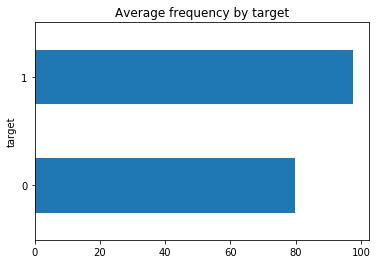

In [18]:
print(df.groupby("target")['frequency_days_ever'].mean())
df.groupby("target")['frequency_days_ever'].mean().plot.barh()
plt.title('Average frequency by target')
plt.show()

target
0     2.621136
1    35.753194
Name: frequency_days_ttm, dtype: float64


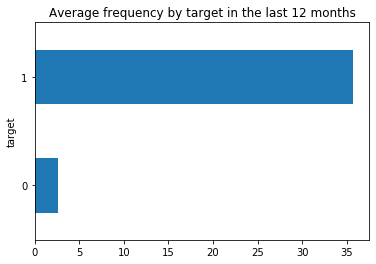

In [19]:
print(df.groupby("target")['frequency_days_ttm'].mean())
df.groupby("target")['frequency_days_ttm'].mean().plot.barh()
plt.title('Average frequency by target in the last 12 months')
plt.show()

target
0    35.856460
1    26.101538
Name: tenure_months, dtype: float64


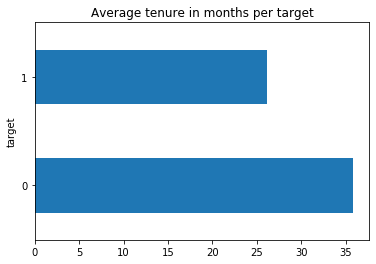

In [20]:
print(df.groupby(["target"])['tenure_months'].mean())
df.groupby(["target"])['tenure_months'].mean().plot.barh()
plt.title('Average tenure in months per target')
plt.show()

#### Adding second layer on top of target split

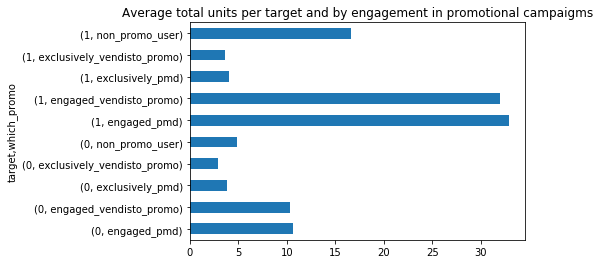

In [21]:
df.groupby(["target","which_promo"])['total_units'].mean().plot.barh()
plt.title('Average total units per target and by engagement in promotional campaigms')
plt.show()

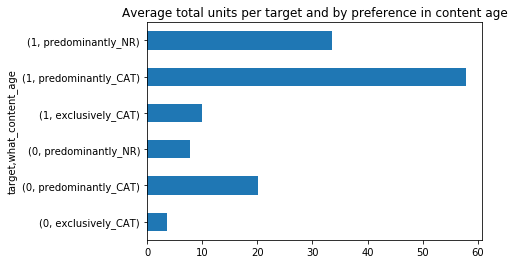

In [22]:
df.groupby(["target","what_content_age"])['total_units'].mean().plot.barh()
plt.title('Average total units per target and by preference in content age')
plt.show()

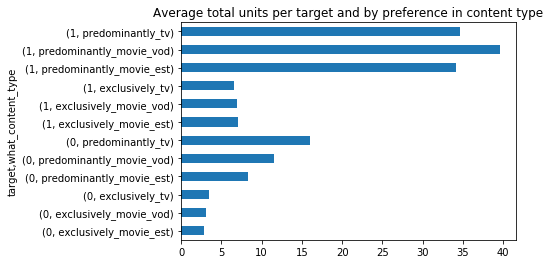

In [23]:
df.groupby(["target","what_content_type"])['total_units'].mean().plot.barh()
plt.title('Average total units per target and by preference in content type')
plt.show()

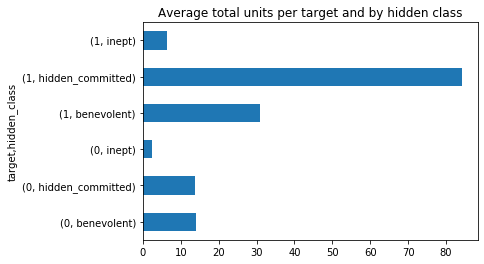

In [24]:
df.groupby(["target","hidden_class"])['total_units'].mean().plot.barh()
plt.title('Average total units per target and by hidden class')
plt.show()

# Preprocessing

### Identify missing values

In [25]:
df.dtypes

encrypted_customerID              object
total_units                        int64
total_revenue                    float64
total_units_ttm                    int64
total_revenue_ttm                float64
adj_units_yearly_ever              int64
adj_revenue_yearlu_ever          float64
adj_units_yearly_before_ttm        int64
adj_revenue_yearly_before_ttm    float64
which_promo                       object
engagement                        object
what_content_age                  object
what_content_type                 object
asp_ever                         float64
asp_ttm                          float64
arpu_monthly_ever                float64
arpu_monthly_ttm                 float64
frequency_days_ever                int64
frequency_days_ttm                 int64
hidden_class                      object
tenure_months                    float64
target                             int64
dtype: object

In [26]:
# Missing values check
df.apply(lambda x: sum(x.isnull()), axis=0)

encrypted_customerID                0
total_units                         0
total_revenue                       0
total_units_ttm                     0
total_revenue_ttm                   0
adj_units_yearly_ever               0
adj_revenue_yearlu_ever             0
adj_units_yearly_before_ttm         0
adj_revenue_yearly_before_ttm       0
which_promo                         0
engagement                          0
what_content_age                    0
what_content_type                   0
asp_ever                            0
asp_ttm                             0
arpu_monthly_ever                3036
arpu_monthly_ttm                    0
frequency_days_ever                 0
frequency_days_ttm                  0
hidden_class                        0
tenure_months                       0
target                              0
dtype: int64

In [27]:
#Fill NA with zeros
df = df.fillna(0)

In [28]:
df.isnull().values.any()

False

In [29]:
df.dtypes

encrypted_customerID              object
total_units                        int64
total_revenue                    float64
total_units_ttm                    int64
total_revenue_ttm                float64
adj_units_yearly_ever              int64
adj_revenue_yearlu_ever          float64
adj_units_yearly_before_ttm        int64
adj_revenue_yearly_before_ttm    float64
which_promo                       object
engagement                        object
what_content_age                  object
what_content_type                 object
asp_ever                         float64
asp_ttm                          float64
arpu_monthly_ever                float64
arpu_monthly_ttm                 float64
frequency_days_ever                int64
frequency_days_ttm                 int64
hidden_class                      object
tenure_months                    float64
target                             int64
dtype: object

### Look at correlation matrix

<p> There are features that exhibit high correlation and they are delted as they add little value to the final model. </p>

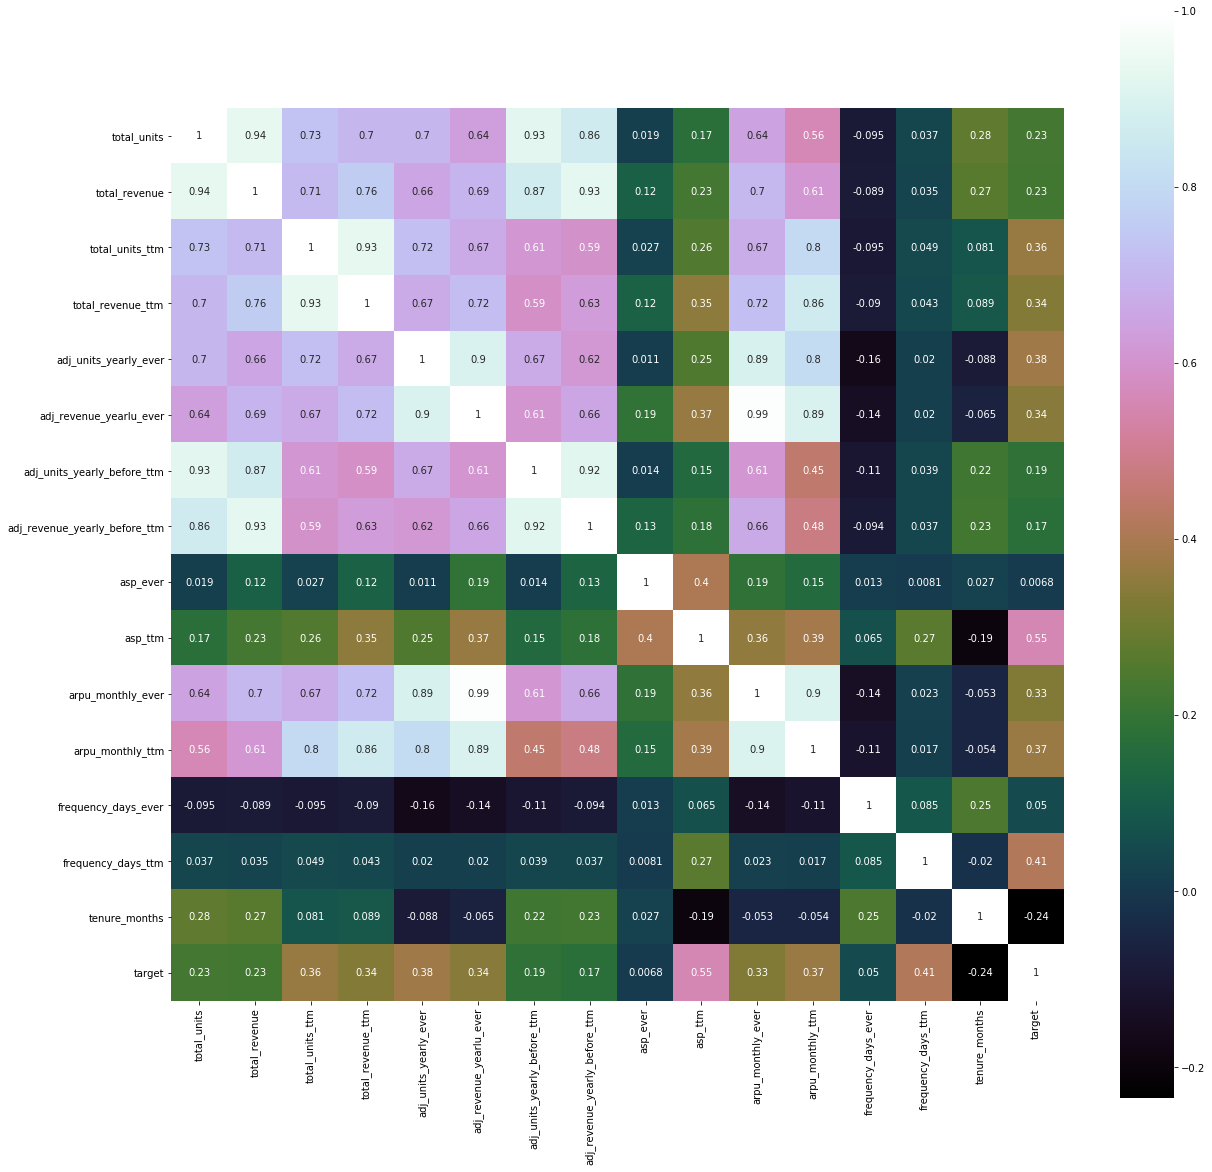

In [30]:
correlation = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

In [31]:
df_subset = df.drop(['adj_units_yearly_ever',
       'adj_revenue_yearlu_ever', 'adj_units_yearly_before_ttm',
       'adj_revenue_yearly_before_ttm',
       'total_revenue','total_revenue_ttm',
       'arpu_monthly_ttm'], axis=1)

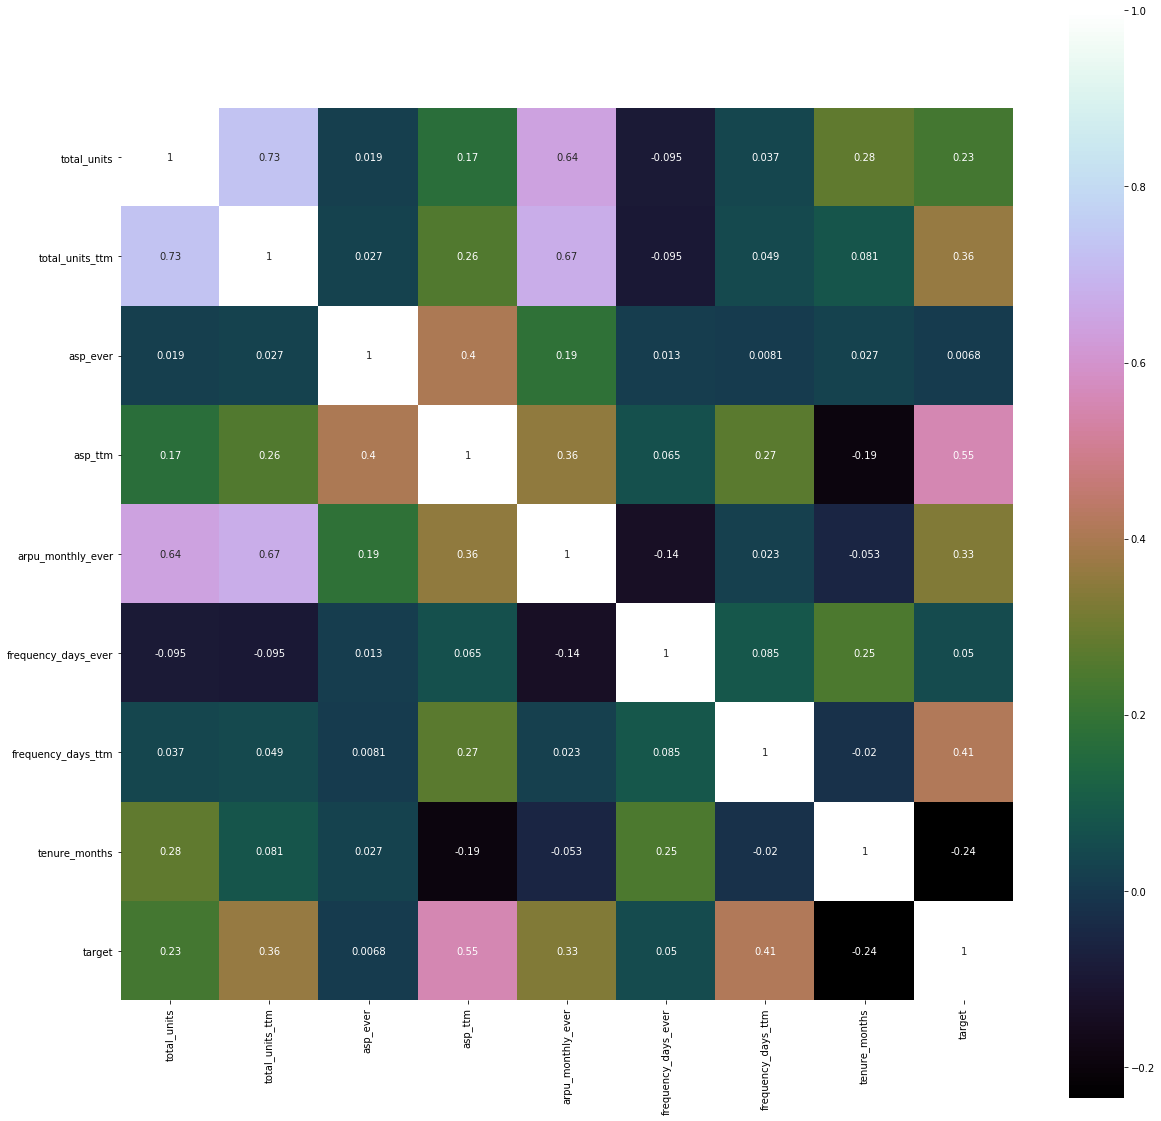

In [32]:
correlation = df_subset.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

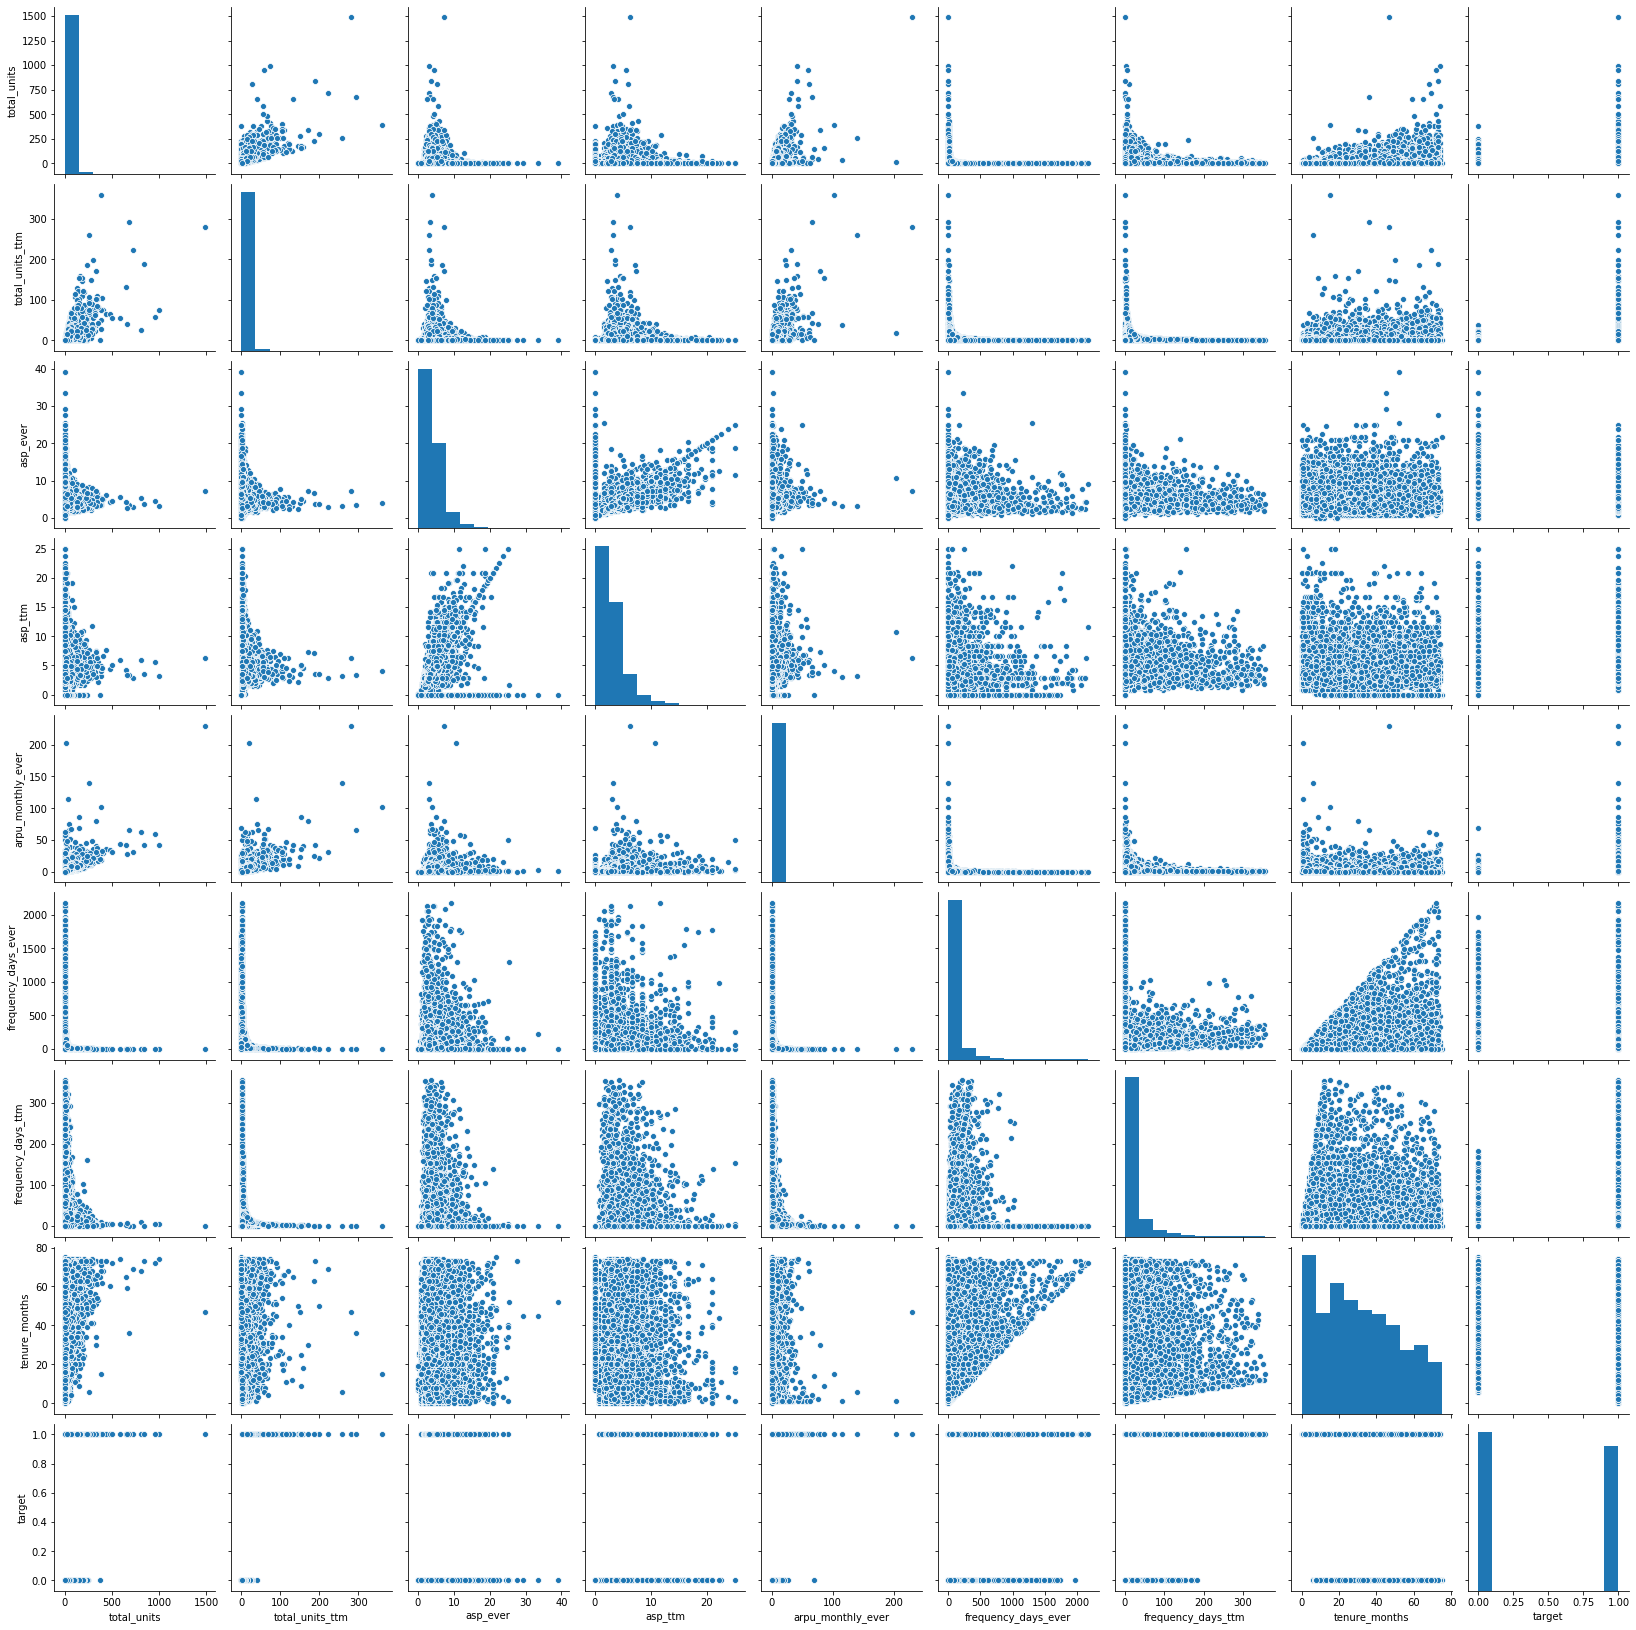

In [33]:
# Take a sample
df_sample = df_subset.sample(frac=0.05)
# Pairwise plots
pplot = sns.pairplot(df_sample)

### One hot encoding

<p> To avoid multicollinearity, columns for which get_dummies were selected, should be deleted. </p>

In [34]:
df_subset.head()

,encrypted_customerID,total_units,total_units_ttm,which_promo,engagement,what_content_age,what_content_type,asp_ever,asp_ttm,arpu_monthly_ever,frequency_days_ever,frequency_days_ttm,hidden_class,tenure_months,target
0,A2GMX5T2DZRSF7,1,1,non_promo_user,one_time,exclusively_CAT,exclusively_movie_vod,0.82,0.82,0.10,0,0,inept,8.0,0
1,AQRAHLBPDBZ1Y,3,0,non_promo_user,moderate,predominantly_NR,predominantly_movie_est,3.16,0.00,0.13,87,0,inept,68.0,0
2,ARDWGB5C81WCO,1,1,non_promo_user,one_time,exclusively_CAT,exclusively_tv,0.82,0.82,0.09,0,0,inept,9.0,0
3,AJ9WP71ARK0VN,4,4,engaged_vendisto_promo,moderate,exclusively_CAT,exclusively_tv,1.19,1.19,0.43,16,16,inept,11.0,0
4,AIP4X46PJ7EBE,149,24,non_promo_user,engaged,predominantly_NR,predominantly_movie_est,6.81,7.30,19.91,10,14,hidden_committed,51.0,1


In [35]:
one_hot_which_promo = pd.get_dummies(df_subset['which_promo'])
one_hot_engagement =  pd.get_dummies(df_subset['engagement'])
one_hot_content_age = pd.get_dummies(df_subset['what_content_age'])
one_hot_content_type = pd.get_dummies(df_subset['what_content_type'])
one_hot_hidden = pd.get_dummies(df_subset['hidden_class'])

In [36]:
df_subset_preprocessed = df_subset.drop(['encrypted_customerID','which_promo','engagement',
                                         'what_content_age','what_content_type','hidden_class'], axis = 1)

In [37]:
print(df_subset_preprocessed.shape)
df_subset_preprocessed.head()

(434724, 9)


,total_units,total_units_ttm,asp_ever,asp_ttm,arpu_monthly_ever,frequency_days_ever,frequency_days_ttm,tenure_months,target
0,1,1,0.82,0.82,0.10,0,0,8.0,0
1,3,0,3.16,0.00,0.13,87,0,68.0,0
2,1,1,0.82,0.82,0.09,0,0,9.0,0
3,4,4,1.19,1.19,0.43,16,16,11.0,0
4,149,24,6.81,7.30,19.91,10,14,51.0,1


In [38]:
df_final = df_subset_preprocessed.join(one_hot_which_promo)
df_final = df_final.join(one_hot_engagement)
df_final = df_final.join(one_hot_content_age)
df_final = df_final.join(one_hot_content_type)
df_final = df_final.join(one_hot_hidden)

In [39]:
print(df_final.shape)
df_final.head()

(434724, 29)


,total_units,total_units_ttm,asp_ever,asp_ttm,arpu_monthly_ever,frequency_days_ever,frequency_days_ttm,tenure_months,target,engaged_pmd,...,predominantly_NR,exclusively_movie_est,exclusively_movie_vod,exclusively_tv,predominantly_movie_est,predominantly_movie_vod,predominantly_tv,benevolent,hidden_committed,inept
0,1,1,0.82,0.82,0.10,0,0,8.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,3,0,3.16,0.00,0.13,87,0,68.0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,1,1,0.82,0.82,0.09,0,0,9.0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,4,4,1.19,1.19,0.43,16,16,11.0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,149,24,6.81,7.30,19.91,10,14,51.0,1,0,...,1,0,0,0,1,0,0,0,1,0


# Modeling

## Split into train and test

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [41]:
X = df_final.drop(['target'], axis = 1)
Y = df_final['target']

In [42]:
df_final.iloc[5:10,10:]

,engaged_vendisto_promo,exclusively_pmd,exclusively_vendisto_promo,non_promo_user,engaged,moderate,one_time,exclusively_CAT,predominantly_CAT,predominantly_NR,exclusively_movie_est,exclusively_movie_vod,exclusively_tv,predominantly_movie_est,predominantly_movie_vod,predominantly_tv,benevolent,hidden_committed,inept
5,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1
6,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
7,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
8,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
9,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [43]:
print(X.shape, Y.shape)

(434724, 28) (434724,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [45]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(291265, 28) (143459, 28) (291265,) (143459,)


## Benchmark model

### Logistic regression

<p> Logistic regression is perfectly suitable for the problem at hand - binary classification. Therefore, its results can be considered benchmark performance. </p>

In [46]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
y_pred_logreg = logreg.predict(X_test)

<Figure size 432x288 with 0 Axes>

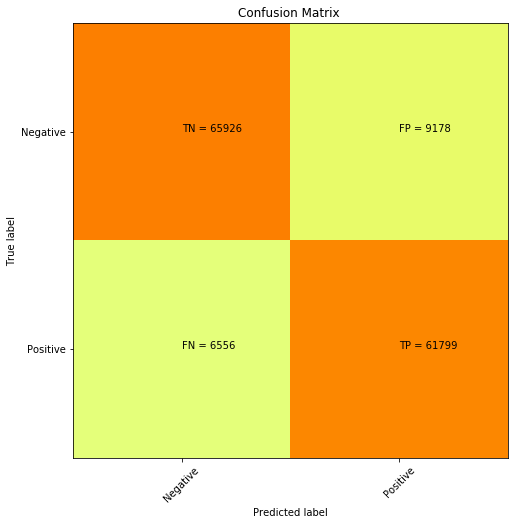

In [48]:
cm = confusion_matrix(y_test, y_pred_logreg)

plt.clf()
plt.figure(figsize = (8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']

plt.title('Confusion Matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [49]:
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Overall accuracy: " , accuracy)
print()
print(classification_report(y_test, y_pred_logreg))

Overall accuracy:  0.8903240647153542

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     75104
           1       0.87      0.90      0.89     68355

    accuracy                           0.89    143459
   macro avg       0.89      0.89      0.89    143459
weighted avg       0.89      0.89      0.89    143459



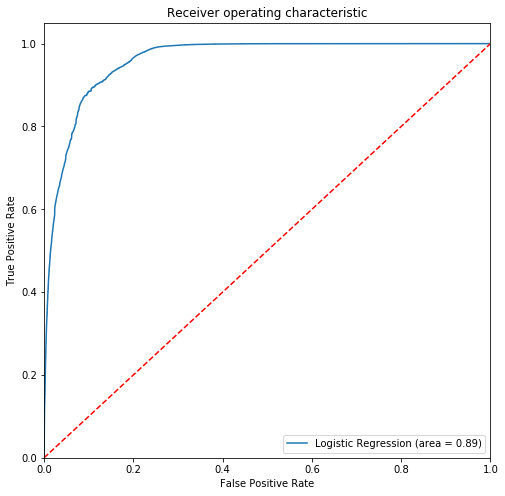

In [50]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Random Forest Classifier

In [51]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train), reverse=True))

Features sorted by their score:
[(0.2054, 'total_units_ttm'), (0.2016, 'asp_ttm'), (0.1352, 'frequency_days_ttm'), (0.1308, 'tenure_months'), (0.1146, 'arpu_monthly_ever'), (0.0786, 'frequency_days_ever'), (0.0421, 'total_units'), (0.0279, 'asp_ever'), (0.0127, 'one_time'), (0.0074, 'non_promo_user'), (0.0048, 'moderate'), (0.0046, 'exclusively_tv'), (0.0046, 'benevolent'), (0.0035, 'inept'), (0.0035, 'hidden_committed'), (0.0033, 'engaged'), (0.003, 'engaged_vendisto_promo'), (0.0025, 'exclusively_movie_vod'), (0.0023, 'exclusively_CAT'), (0.0021, 'engaged_pmd'), (0.002, 'predominantly_movie_est'), (0.0016, 'predominantly_NR'), (0.0016, 'exclusively_movie_est'), (0.001, 'predominantly_movie_vod'), (0.001, 'exclusively_vendisto_promo'), (0.0009, 'predominantly_tv'), (0.0009, 'exclusively_pmd'), (0.0003, 'predominantly_CAT')]


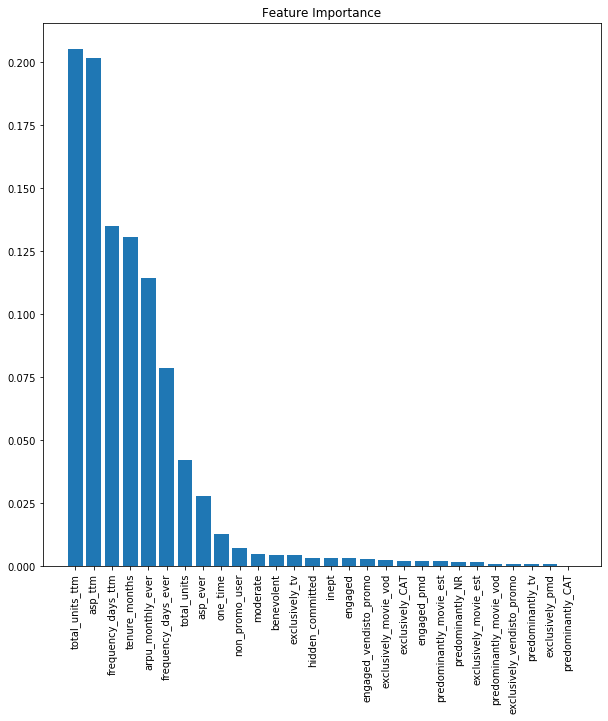

In [53]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize = (10,10))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()


In [54]:
y_predicted = rf.predict(X_test)

<Figure size 432x288 with 0 Axes>

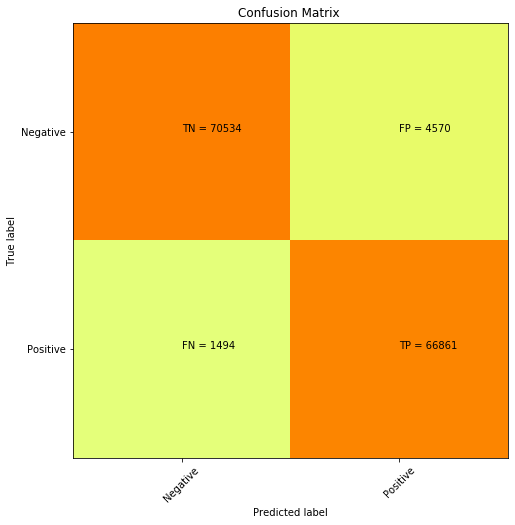

In [55]:
cm = confusion_matrix(y_test, y_predicted)

plt.clf()
plt.figure(figsize = (8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']

plt.title('Confusion Matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [56]:
accuracy = accuracy_score(y_test, y_predicted)
print("Overall accuracy: " , accuracy)
print()
print(classification_report(y_test, y_predicted))

Overall accuracy:  0.9577300831596484

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     75104
           1       0.94      0.98      0.96     68355

    accuracy                           0.96    143459
   macro avg       0.96      0.96      0.96    143459
weighted avg       0.96      0.96      0.96    143459



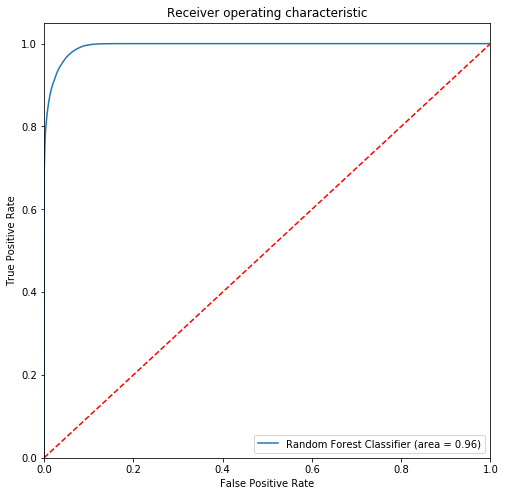

In [57]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [58]:
df_final.head()

,total_units,total_units_ttm,asp_ever,asp_ttm,arpu_monthly_ever,frequency_days_ever,frequency_days_ttm,tenure_months,target,engaged_pmd,...,predominantly_NR,exclusively_movie_est,exclusively_movie_vod,exclusively_tv,predominantly_movie_est,predominantly_movie_vod,predominantly_tv,benevolent,hidden_committed,inept
0,1,1,0.82,0.82,0.10,0,0,8.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,3,0,3.16,0.00,0.13,87,0,68.0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,1,1,0.82,0.82,0.09,0,0,9.0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,4,4,1.19,1.19,0.43,16,16,11.0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,149,24,6.81,7.30,19.91,10,14,51.0,1,0,...,1,0,0,0,1,0,0,0,1,0


## Use only the most important features

In [59]:
# Select only the most important features

df_small = df_final[['asp_ttm','frequency_days_ttm','total_units_ttm',
                    'tenure_months','arpu_monthly_ever','frequency_days_ever','total_units','asp_ever','target']]

In [60]:
df_small.head()

,asp_ttm,frequency_days_ttm,total_units_ttm,tenure_months,arpu_monthly_ever,frequency_days_ever,total_units,asp_ever,target
0,0.82,0,1,8.0,0.10,0,1,0.82,0
1,0.00,0,0,68.0,0.13,87,3,3.16,0
2,0.82,0,1,9.0,0.09,0,1,0.82,0
3,1.19,16,4,11.0,0.43,16,4,1.19,0
4,7.30,14,24,51.0,19.91,10,149,6.81,1


In [61]:
X = df_small.drop(['target'], axis = 1)
Y = df_small['target']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
y_predicted = rf.predict(X_test)

In [65]:
accuracy = accuracy_score(y_test, y_predicted)
print("Overall accuracy: " , accuracy)
print()
print(classification_report(y_test, y_predicted))

Overall accuracy:  0.9665897573522748

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     75104
           1       0.95      0.98      0.97     68355

    accuracy                           0.97    143459
   macro avg       0.97      0.97      0.97    143459
weighted avg       0.97      0.97      0.97    143459



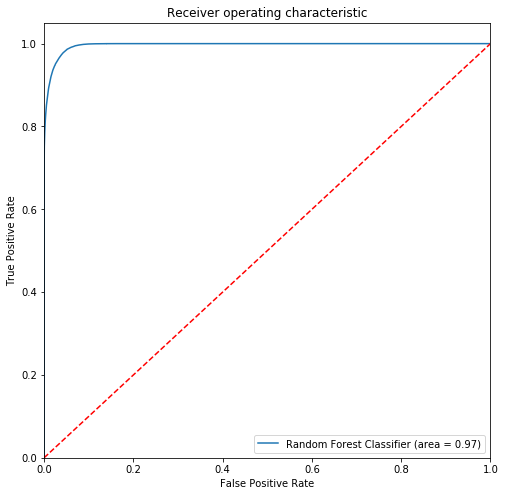

In [66]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()